# VA DEQ & StreamStats Feature Engineering

The purpose of this Jupyter notebook is to load data cleaned in another notebook and transform the data appropriately. This dataset will be ready for model training.

EDA was conducted prior at \\models\\model1_streamstats_va\\eda\\VADEQ_Stmsts_EDA.ipynb

Emma Reilly Oare

In [1]:
# Standard Libraries
import os  # File handling and directory management
import warnings  # Suppress warnings

# Data Handling
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# Visualization
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns  # Statistical visualization

# Machine Learning & Feature Engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder  # Scaling & encoding
from sklearn.decomposition import PCA  # Dimensionality reduction
from sklearn.feature_selection import SelectKBest, f_regression  # Feature selection

# Suppress warnings
warnings.filterwarnings("ignore")

## Step 1. Import dataset

In [2]:
# Define base directory
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../.."))

In [3]:
# Read in file
vadeq_path = os.path.join(BASE_DIR, "data", "processed", "virginia", "vadeq_strmsts_after_eda.xlsx")
vadeq_strmsts = pd.read_excel(vadeq_path).drop(columns = ['Unnamed: 0'])

In [4]:
# Display data frame
vadeq_strmsts

,StationID,Xembed,STATSGODEP,ELEV,STATSCLY20,RELIEF,STATSPERM,STATSCLY50,LC11FORSHB,LC11CRPHAY,I24H2Y,PRECIP,Year,DRNAREA_SQKM,PKREGNO_1550,PKREGNO_1551,PKREGNO_1552,PKREGNO_1553,PKREGNO_1554,PKREGNO_1555
0,1AACO006.10,62.545455,70.48,148.98,0.00,171.0,2.895,0.00,16.23,0.00,3.140,43.078,2006,0.181817,False,True,False,False,False,False
1,1AACO004.84,51.636364,66.65,308.44,51.85,451.0,2.395,0.00,22.49,0.11,3.167,43.888,2008,104.894595,True,False,False,False,False,False
2,1AACO006.10,56.818182,70.48,148.98,0.00,171.0,2.895,0.00,16.23,0.00,3.140,43.078,2008,0.181817,False,True,False,False,False,False
3,1AACO009.14,63.454545,66.39,324.56,54.64,357.0,2.271,0.00,22.65,0.09,3.169,43.981,2008,94.016637,False,True,False,False,False,False
4,1AAUA017.60,65.454545,56.77,317.16,0.30,278.0,1.506,0.00,67.67,7.74,3.055,43.317,2005,76.922703,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,2BXRK001.64,67.090909,68.00,796.84,0.00,575.0,2.000,0.00,95.34,0.00,3.723,49.307,2022,1.968392,False,False,False,True,False,False
1113,2-JKS070.06,27.636364,44.64,2821.90,69.18,2550.0,5.089,0.00,77.43,17.98,2.959,43.163,2022,269.358960,False,False,False,False,True,False
1114,4ASNA007.82,95.909091,71.04,604.47,0.00,691.0,1.114,90.49,60.89,23.17,3.319,45.609,2022,206.940201,False,True,False,False,False,False
1115,8-MIC001.47,89.090909,72.00,298.12,0.00,197.0,1.000,100.00,41.15,49.07,3.290,43.671,2022,14.633444,False,True,False,False,False,False


## Step 2. Feature Engineering

We will explore transforming the feature sets to more closely follow a Gaussian distribution. We will use visual and statistical methods to select the best transformation tested. We will test:
- log
- square root
- power
- box-cox
- reciprocal
- Yeo-Johnson Power Transformation
- Normal Quantile Transformation

We will go through each feature individually below.

### 2a. Visualize Transformations

In [5]:
# Define function for applying transformations
def apply_transformation(data, transform):
    if transform == 'log':
        return np.log(data + 1)
    elif transform == 'sqrt':
        return np.sqrt(data)
    elif transform == 'cbrt':
        return np.power(data, 1/3)
    elif transform == 'boxcox':
        if (data > 0).all():
            return stats.boxcox(data)[0]
        else:
            return None
    elif transform == 'reciprocal':
        return 1 / (data + 1)
    elif transform == 'yeo_johnson':
        pt = PowerTransformer(method='yeo-johnson')
        return pt.fit_transform(data.values.reshape(-1, 1)).flatten()
    elif transform == 'quantile_normal':
        qt = QuantileTransformer(output_distribution='normal')
        return qt.fit_transform(data.values.reshape(-1, 1)).flatten()
    else:
        return data

# Define function for evaluating normality based on statistical measures (Shapiro and Anderson)
def evaluate_normality(data):
    shapiro_stat, shapiro_p_value = stats.shapiro(data)
    ad_stat, ad_critical_values, ad_significance_level = stats.anderson(data, dist='norm')
    return {
        'shapiro_stat': shapiro_stat,
        'shapiro_p_value': shapiro_p_value,
        'ad_stat': ad_stat,
        'ad_significance_level': ad_significance_level
    }

# Define function that uses apply_transformation and evaluate_normality to visualize and test for normality
def normality(data, feature):
    transformations = {
        'Original': None,
        'Log': 'log',
        'Square Root': 'sqrt',
        'Cube Root': 'cbrt',
        'Box-Cox': 'boxcox',
        'Reciprocal': 'reciprocal',
        'Yeo-Johnson': 'yeo_johnson',
        'Quantile Normal': 'quantile_normal'
    }

    results = {}

    fig, axes = plt.subplots(len(transformations), 2, figsize=(15, 5 * len(transformations)))

    # Handle infinite values in the original data
    original_data = data[feature].replace([np.inf, -np.inf], np.nan).dropna()

    for i, (name, transform) in enumerate(transformations.items()):
        if transform is None:
            transformed_data = original_data
        else:
            transformed_data = apply_transformation(original_data, transform)
            if transformed_data is None:
                axes[i, 0].set_visible(False)
                axes[i, 1].set_visible(False)
                continue

        # Plot two normality plots -> KDE and Q-Q
        sns.kdeplot(transformed_data, ax=axes[i, 0])
        axes[i, 0].set_title(f'{name} KDE')
        stats.probplot(transformed_data, plot=axes[i, 1])
        axes[i, 1].set_title(f'{name} Q-Q plot')

        # Evaluate normality
        result = evaluate_normality(transformed_data)
        results[name] = result

    plt.tight_layout()
    plt.show()

    # Print the results
    for name, result in results.items():
        print(f'{name} Transformation:')
        print(f'  Shapiro-Wilk Test Statistic = {result["shapiro_stat"]:.4f}, p-value = {result["shapiro_p_value"]:.4f}')
        print(f'  Anderson-Darling Test Statistic = {result["ad_stat"]:.4f}, Significance Level = {result["ad_significance_level"]}\n')

    # Find and print the best transformation based on Shapiro-Wilk Test
    best_transformation = max(results, key=lambda x: results[x]['shapiro_stat'])
    print(f'Best transformation according to Shapiro-Wilk Test: {best_transformation}')

    # Find and print the best transformation based on Anderson-Darling Test
    best_ad_transformation = min(results, key=lambda x: results[x]['ad_stat'])
    print(f'Best transformation according to Anderson-Darling Test: {best_ad_transformation}')

#### STATSGODEP

NameError: name 'stats' is not defined

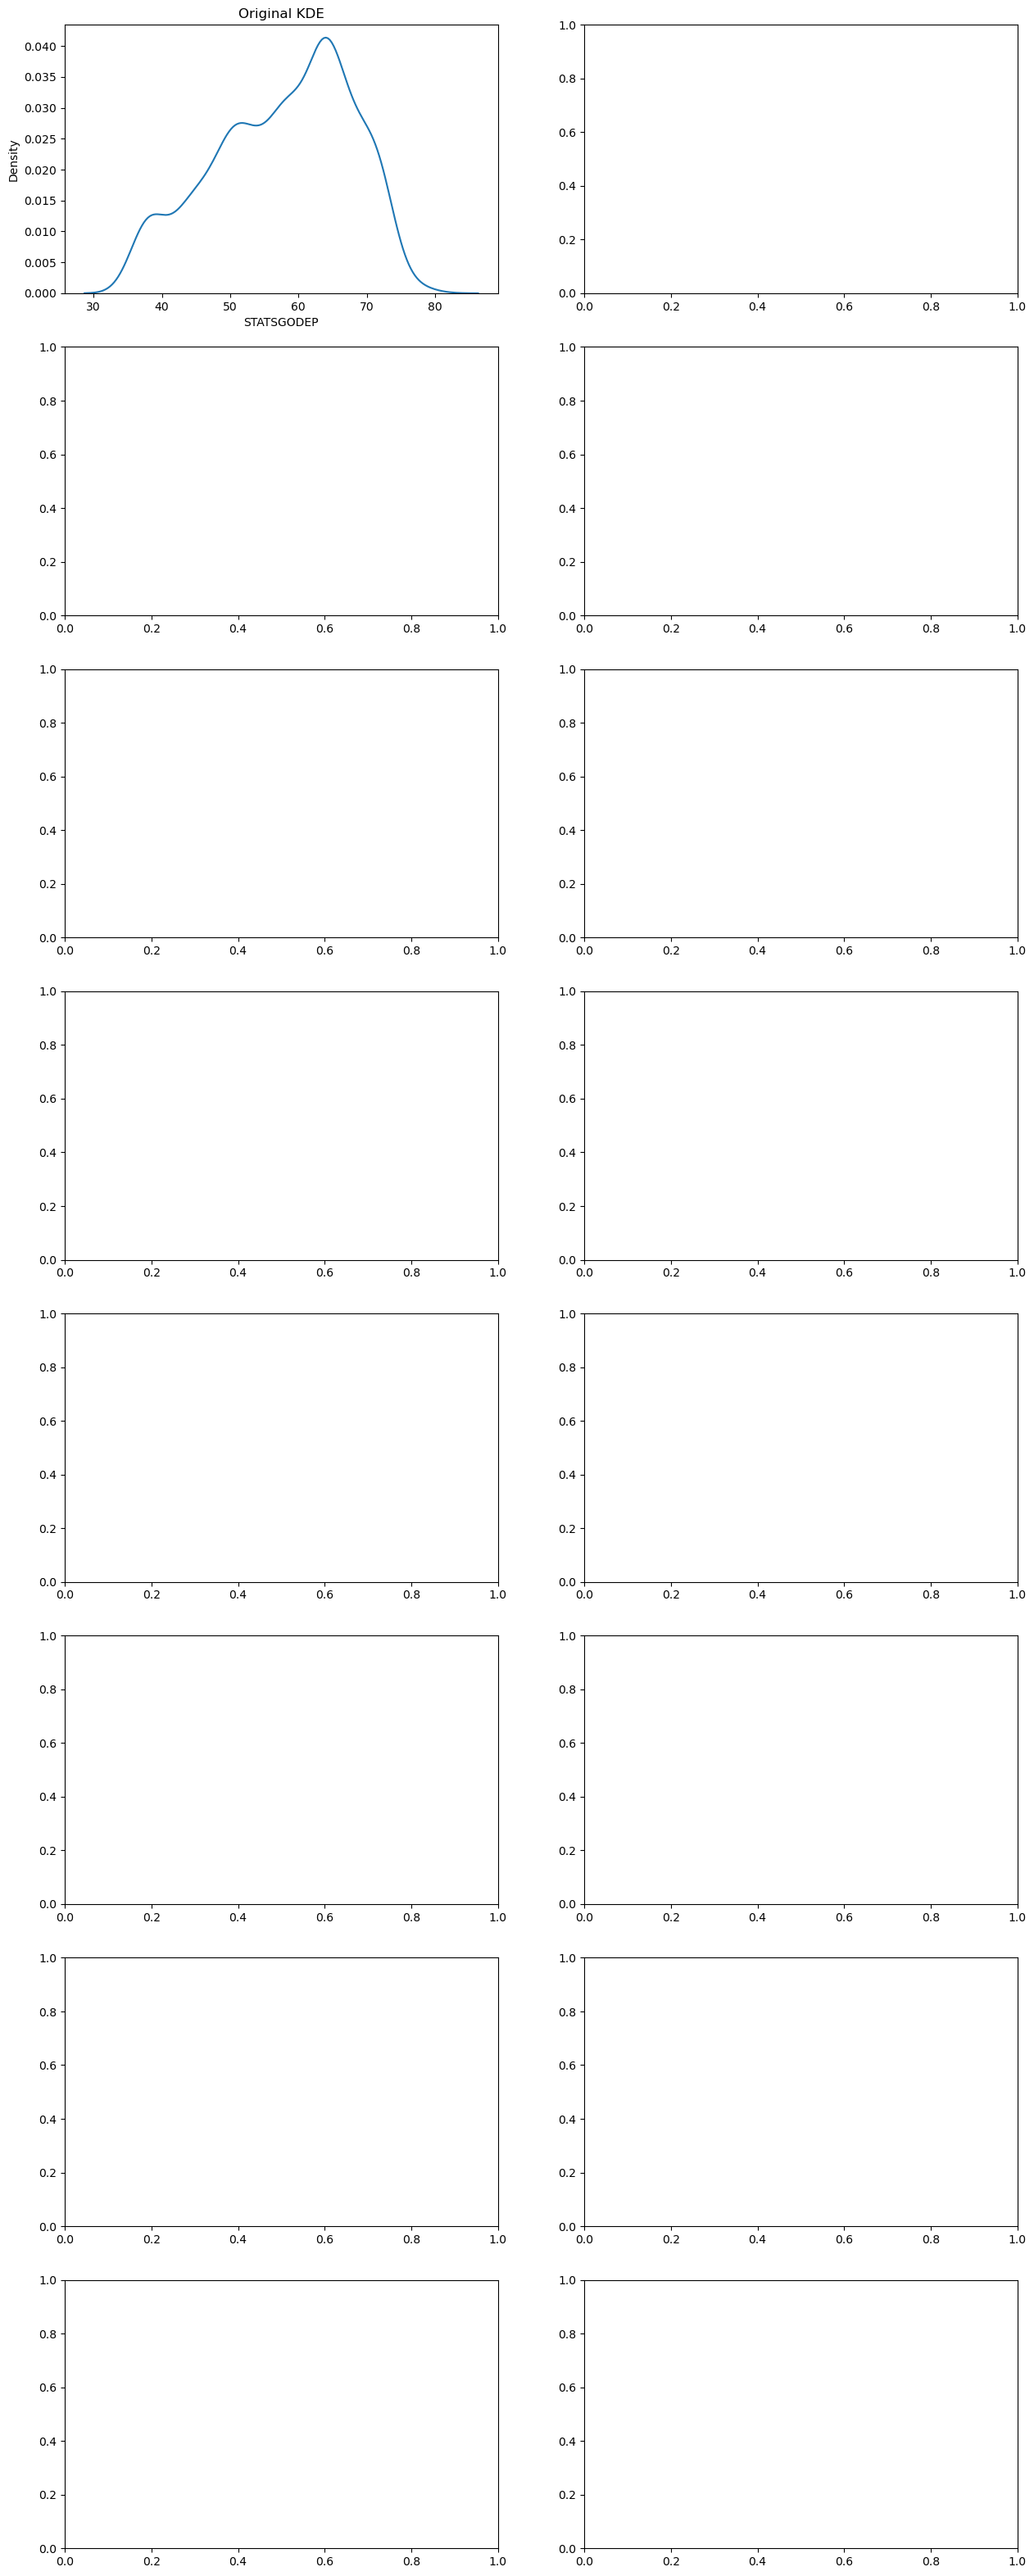

In [6]:
# Normality plots for STATSGODEP feature
normality(vadeq_strmsts, 'STATSGODEP')

#### ELEV

In [ ]:
# Normality plots for ELEV feature
normality(vadeq_strmsts, 'ELEV')

#### PKREGNO --> Not transformed given it is a category/group/cluster

#### STATSCLY20

In [ ]:
# Normality plots for STATSCLY20
normality(vadeq_strmsts, 'STATSCLY20')

#### RELIEF

In [ ]:
#Normality plots for RELIEF
normality(vadeq_strmsts, 'RELIEF')

#### STATSPERM

In [ ]:
#Normality plots for STATSPERM
normality(vadeq_strmsts, 'STATSPERM')

#### STATSCLY50

In [ ]:
#Normality plots for STATSCLY50
normality(vadeq_strmsts, 'STATSCLY50')

#### LC11FORSHB

In [ ]:
#Normality plots for LC11FORSHB
normality(vadeq_strmsts, 'LC11FORSHB')

#### LC11CRPHAY

In [ ]:
#Normality plots for LC11CRPHAY
normality(vadeq_strmsts, 'LC11CRPHAY')

#### I24H2Y

In [ ]:
#Normality plots for I24H2Y
normality(vadeq_strmsts, 'I24H2Y')

#### PRECIP

In [ ]:
#Normality plots for PRECIP
normality(vadeq_strmsts, 'PRECIP')

#### Year

In [ ]:
#Normality plot for Year
normality(vadeq_strmsts, 'Year')

#### DRNAREA_SQKM

In [ ]:
#Normality plots for DRNAREA_SQKM
normality(vadeq_strmsts, 'DRNAREA_SQKM')

### Step 2b. Apply transformations

In [ ]:
# Define transformers
pt = PowerTransformer(method = 'yeo-johnson')
qt = QuantileTransformer(output_distribution = 'normal')

In [ ]:
# Transform features based on visual and statistical results from above

# Create new transformed column for each feature required
vadeq_strmsts['Area-weighted average soil depth (QT)'] = qt.fit_transform(vadeq_strmsts['STATSGODEP'].values.reshape(-1, 1))
vadeq_strmsts['Mean Basin Elevation (QT)'] = qt.fit_transform(vadeq_strmsts['ELEV'].values.reshape(-1, 1))
vadeq_strmsts['% of Soils with greater than 10% and less than 20% Clay (sqrt)'] = np.sqrt(vadeq_strmsts['STATSCLY20'])
vadeq_strmsts['Relief (QT)'] = qt.fit_transform(vadeq_strmsts['RELIEF'].values.reshape(-1, 1))
vadeq_strmsts['Area-weighted Average Soil Permeability (log)'] = np.log((vadeq_strmsts['STATSPERM']) + 1)
vadeq_strmsts['% of Soils with greater than 40% and less than 50% Clay (cbrt)'] = np.power(vadeq_strmsts['STATSCLY50'], 1/3)
vadeq_strmsts['% of Forests and Shrub Lands (NLCD 2011) (YJ)'] = pt.fit_transform(vadeq_strmsts['LC11FORSHB'].values.reshape(-1, 1))
vadeq_strmsts['% of Cultivated Crop and Pasture (NLCD 2011) (sqrt)'] = np.sqrt(vadeq_strmsts['LC11CRPHAY'])
vadeq_strmsts['Max 24-Hour Precipitation for 2-Year Return Period (QT)'] = qt.fit_transform(vadeq_strmsts['I24H2Y'].values.reshape(-1, 1))
vadeq_strmsts['Mean Annual Precipitation (QT)'] = qt.fit_transform(vadeq_strmsts['PRECIP'].values.reshape(-1, 1))
vadeq_strmsts['Drainage Area (sq km) (QT)'] = qt.fit_transform(vadeq_strmsts['DRNAREA_SQKM'].values.reshape(-1, 1))

In [ ]:
# Select columns based on visual and statistical results
vadeq_strmsts = vadeq_strmsts[['StationID',
                                 'Xembed',
                                'Area-weighted average soil depth (QT)',
                                'Mean Basin Elevation (QT)',
                                '% of Soils with greater than 10% and less than 20% Clay (sqrt)',
                                'Relief (QT)',
                                'Area-weighted Average Soil Permeability (log)', 
                                '% of Soils with greater than 40% and less than 50% Clay (cbrt)',
                                '% of Forests and Shrub Lands (NLCD 2011) (YJ)',
                                '% of Cultivated Crop and Pasture (NLCD 2011) (sqrt)',
                                'Max 24-Hour Precipitation for 2-Year Return Period (QT)',
                                'Mean Annual Precipitation (QT)',
                                'Year', # Original has same Shapiro-Wilk stat AND time is best left unchanged,
                                'Drainage Area (sq km) (QT)',
                                'PKREGNO_1550', # No need to change due to categorical columns
                               'PKREGNO_1551',
                               'PKREGNO_1552',
                               'PKREGNO_1553',
                               'PKREGNO_1554',
                               'PKREGNO_1555']]

In [ ]:
# Rename respective columns for plotting purposes
vadeq_strmsts = vadeq_strmsts.rename(columns = {'StationID':'Station ID',
                                                  'Xembed':'Mean Streambed Embeddedness (%)',
                                                  'LC11CRPHAY':'% of Cultivated Crops and Hay (NLCD 2011)',
                                                  'PKREGNO_1550.0':'Peak Flow Region Number 1550',
                                                  'PKREGNO_1551.0':'Peak Flow Region Number 1551',
                                                  'PKREGNO_1552.0':'Peak Flow Region Number 1552',
                                                  'PKREGNO_1553.0':'Peak Flow Region Number 1553',
                                                  'PKREGNO_1554.0':'Peak Flow Region Number 1554',
                                                  'PKREGNO_1555.0':'Peak Flow Region Number 1555'})

In [ ]:
# Display dataframe
vadeq_strmsts

## Step 3. Export to Excel

In [ ]:
# Create path and push to model_ready folder
mdl_path = os.path.join(BASE_DIR, "data", "model_ready", "vadeq_strmsts_mdl.xlsx")
vadeq_strmsts.to_excel(mdl_path)